# Projeto 6 - Doenças Infecciosas

João Victor Dell Agli Floriano, 10799783

## Introdução

A Influenza em humanos, causada por três tipos de vírus diferentes (A, B, C e seus subtipos), é uma doença respiratória que acomete a espécie humana há milênios, com alguns dos primeiros registros de uma epidemia em 6000 BCE. Seus sintomas incluem febre aguda, tosse, garganta inflamada, dores no corpo e indisposição, com intensidade dos sintomas a depender do tipo de vírus infectado e de sua carga viral.

![](https://upload.wikimedia.org/wikipedia/commons/a/a4/EM_of_influenza_virus.jpg)

A Influenza já possui prevenção por meio de vacinação, que é realizada anualmente pelo [Ministério da Saúde](https://www.gov.br/saude/pt-br/assuntos/saude-de-a-a-z/g/gripe-influenza), e é recomendada a todas as idades, apesar de perder eficiência em idosos.

## Modelagem

Para modelar a Influenza, usaremos de base o modelo SIR (Suscetível, Infectado, Removido), com algumas alterações. A primeira alteração levará em conta a sazonalidade do vírus, que tende a incidir com maior frequência em épocas de inverno, quando por diminuição da temperatura, uma maior quantidade de poluição e patógenos se assentam perto da superfície, causando queda de imunidade e problemas respiratórios. Para levar a sazonalidade em conta, introduziremos uma dependência temporal na tradicional variável de transmissão, $\beta$, que contará com um comportamento gaussiano periódico do seguinte formato:

$$\beta (t) = Be^{-Csen(\omega t + \phi)^2} + D$$

Sendo cada parâmetro:

* $B$ : Amplitude da transmissão 
* $C$ : Rapidez da transmissão
* $\omega$ : Frequência anual
* $\phi$ : Estado inicial da transmissão
* $D$ : Valor base de transmissão

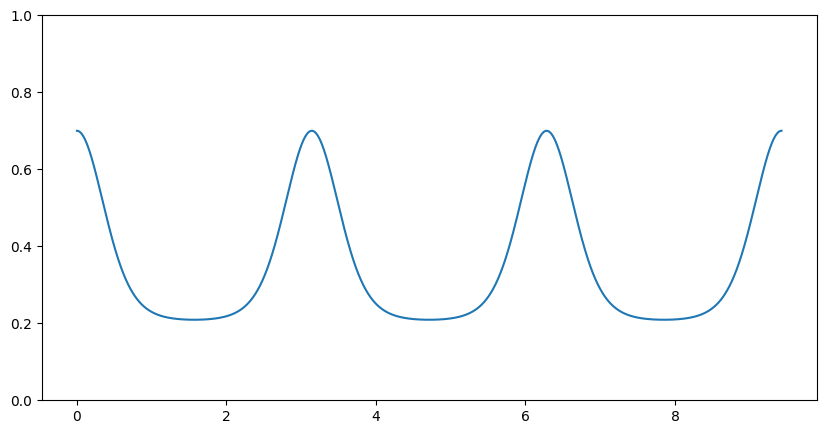

In [170]:
import numpy as np
import matplotlib.pyplot as plt

def beta(t, b, c, d, omega, offset):
    return b*np.exp(-c*(np.sin(omega*t + offset)**2)) + d

T = 3*np.pi
Tn = np.linspace(0.0, T, 10000)

plt.figure(figsize = (10, 5))
plt.ylim(0.0, 1.0)
plt.plot(Tn, beta(Tn, 0.5, 4.0, 0.2, 1.0, 0.0))

A segunda alteração será a adição de uma taxa de perda de imunidade $\delta$ à população de removidos. Essa taxa levará em conta possíveis mutações dos vírus, um fenômeno extremamente comum, que poderão levar ao escapamento dos mesmos dos mecanismos de defesa anteriormente desenvolvidos pelo corpo dos infectados.



Levando em conta então essas alterações, o modelo SIR para a Influenza se torna:

$$\frac{dS(t)}{dt} = -\beta (t) S I + \delta R$$

$$\frac{dI(t)}{dt} = \beta (t) S I - \gamma I$$

$$\frac{dR(t)}{dt} = \gamma I - \delta R$$



* $S$ : Suscetíveis
* $I$ : Infectados
* $R$ : Removidos
* $\beta (t)$ : Taxa de transmissão sazonal do vírus
* $\gamma$ : Taxa de recuperação dos infectados
* $\delta$ : Taxa de mutações que escapam a imunidade

É possível averiguar pelo modelo acima que estamos trabalhando com uma população constante, ou seja $\frac{dS(t)}{dt} + \frac{dI(t)}{dt} + \frac{dR(t)}{dt} = 0$, que se traduz em $S + I + R = N$.

## Condição para Epidemia

Para que uma epidemia aconteça, $\frac{dI}{dt} > 0$, ou seja:

$$\beta (t) S I - \gamma I > 0$$

$$\beta (t) S I  > \gamma I$$

$$ S  > \frac{\gamma}{\beta (t)}$$

Portanto, se $S$ for maior que $\frac{\gamma}{\beta (t)}$, uma epidemia acontece.

## Pontos fixos e estabilidade

Para analisar os pontos fixos, devemos analisar os pontos os quais as três equações diferenciais são iguals a zero:

$$\frac{dS(t)}{dt} = -\beta (t) S I + \delta R = 0$$

$$\frac{dI(t)}{dt} = \beta (t) S I - \gamma I = 0$$

$$\frac{dR(t)}{dt} = \gamma I - \delta R = 0$$

Para $\frac{dS(t)}{dt}$:

$$\frac{dS(t)}{dt} = -\beta (t) S I + \delta R = 0$$

$$-\beta (t) S^* I^*  = -\delta R^*$$

$$ S^*  = \frac{\delta R^*}{\beta (t)I^*}$$

Para $\frac{dI(t)}{dt}$:

$$\frac{dI(t)}{dt} = \beta (t) S^* I^* - \gamma I^* = 0$$

$$(\beta (t) S^*  - \gamma) I^* = 0$$

Para $\frac{dR(t)}{dt}$:

$$\frac{dR(t)}{dt} = \gamma I - \delta R = 0$$

$$ \delta R^* = \gamma I^*$$

$$ R^* = \frac{\gamma I^*}{\delta}$$

A resolução dessas três equações nos rende os seguintes resultados:

* $ S^*  = \frac{\gamma }{\beta (t)}$
* $(\beta (t) S^*  - \gamma) I^* = 0$
* $ R^* = \frac{\gamma I^*}{\delta}$


Sendo assim, encontramos dois pontos:

1. $(S^*  = \frac{\gamma}{\beta (t)}, 0, 0)$

2. $(S^*  = \frac{\gamma}{\beta (t)}, I^*, \frac{\gamma I^*}{\delta})$

Percebe-se que $S^* = \frac{\gamma}{\beta (t)}$ é um valor fixo de $S$ característico dos dois pontos de equilíbrio possíveis. Com relação ao primeiro, temos $I^* = 0$, portanto, não há espalhamento da doença. Já, no segundo, há equilíbrio se, para qualquer valor de $I*$, $R = \frac{\gamma I^*}{\delta}$.

## Implementação

Implementando as equações acima, obtemos os seguintes resultados:

In [171]:
from scipy.integrate import odeint

In [172]:
def SIRt(y, t, beta, gamma, delta, *args):
    """Função que modela o comportamento do SIR com parâmetro beta com variação temporal.
    """
    Sn, In, Rn = y
    dS = - beta(t, *args)*Sn*In + delta*Rn 
    dI = beta(t, *args)*Sn*In -gamma*In 
    dR = gamma*In - delta*Rn 
    return dS, dI, dR


Fixando o tamanho total da população como $1$, ou seja, $S + I + R = 1$, podemos testar o comportamento desse modelo par alguns casos. Para o caso de 
* $S_0 = 0.9$ 
* $I_0 = 0.1$ 
* $R_0 = 0.0$

E demais parâmetros de $\Beta (t)$:

* $\gamma = 0.19$
* $\delta = 0.05$
* $\omega = \frac{2}{365}$ (Pico duas vezes por ano)
* $b = 0.5$
* $c = 1.0$
* $d = 0.1$
* $\phi = 1.0$,

Temos, nos primeiros 365 dias:

In [173]:
S0 = 0.9
I0 = 0.1
R0 = 0.0
T = 365

y0 = S0, I0, R0

gamma = 0.19
delta = 0.05
omega = 2.0/365.0
b = 0.5
c = 1.0
d = 0.1
offset = 1.0

Tn = np.linspace(0.0, T, 1000)

In [174]:
r = odeint(SIRt, y0, Tn, args = (beta, gamma, delta, b, c, d, omega, offset))

S, I, R = r.T

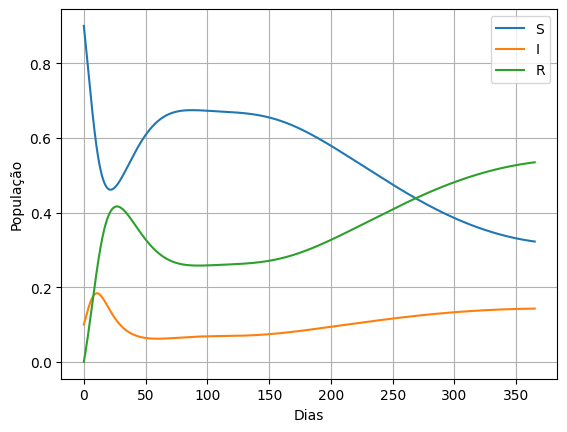

In [175]:

plt.plot(Tn, S, label = "S")
plt.plot(Tn, I, label = "I")
plt.plot(Tn, R, label = "R")
plt.xlabel("Dias")
plt.ylabel("População")
plt.grid()
plt.legend()
plt.show()

Depois, nos primeiros 1500 dias:

In [176]:
T = 1500

Tn = np.linspace(0.0, T, 1000)

In [177]:
r = odeint(SIRt, y0, Tn, args = (beta, gamma, delta, b, c, d, omega, offset))

S, I, R = r.T

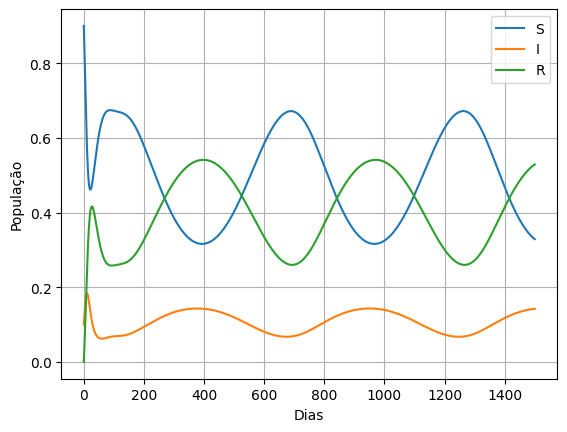

In [178]:

plt.plot(Tn, S, label = "S")
plt.plot(Tn, I, label = "I")
plt.plot(Tn, R, label = "R")
plt.xlabel("Dias")
plt.ylabel("População")
plt.grid()
plt.legend()
plt.show()

Pelo seu diagrama de fase, é possível perceber que o modelo com esses parâmetros encontra certa estabilidade de comportamento após determinado tempo:

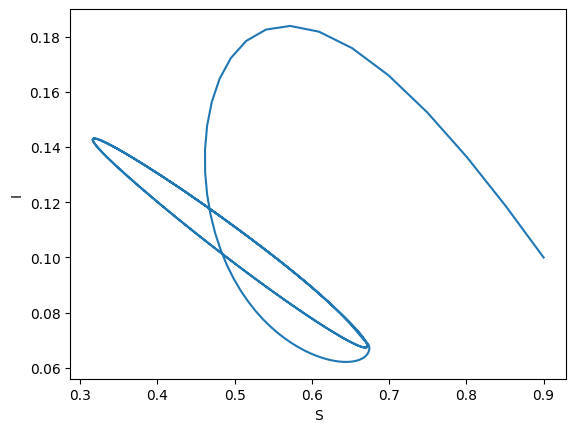

In [179]:
plt.plot(S, I)
plt.xlabel("S")
plt.ylabel("I")
plt.show()

Para a mesma distribuição inicial de população, mas agora com a amplitude de transmissão $b = 0.9$ e um valor base $d = 0.3$, temos:

In [180]:
S0 = 0.9
I0 = 0.1
R0 = 0.0
T = 1000

y0 = S0, I0, R0

gamma = 0.19
delta = 0.05
omega = 2.0/365.0
b = 0.9
c = 1.0
d = 0.3
offset = 1.0


Tn = np.linspace(0.0, T, 1000)

In [181]:
r = odeint(SIRt, y0, Tn, args = (beta, gamma, delta, b, c, d, omega, offset))

S, I, R = r.T

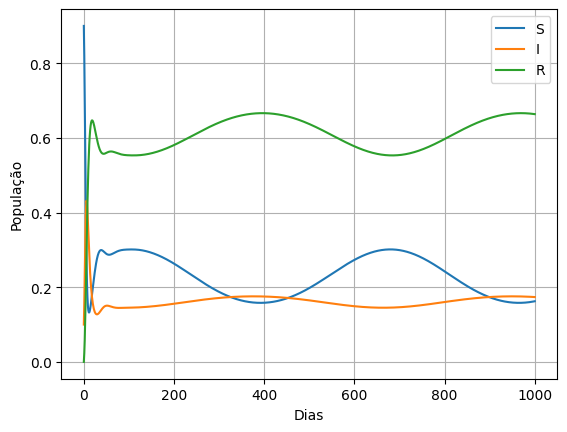

In [182]:
plt.plot(Tn, S, label = "S")
plt.plot(Tn, I, label = "I")
plt.plot(Tn, R, label = "R")
plt.xlabel("Dias")
plt.ylabel("População")
plt.grid()
plt.legend()
plt.show()

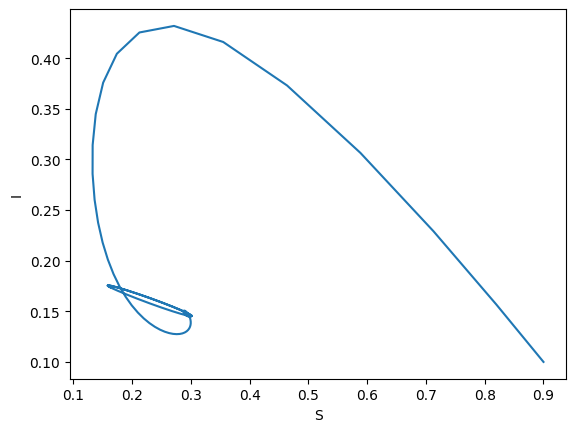

In [183]:
plt.plot(S, I)
plt.xlabel("S")
plt.ylabel("I")
plt.show()

## Referências:

* Gripe (influenza), Ministério da Saúde: https://www.gov.br/saude/pt-br/assuntos/saude-de-a-a-z/g/gripe-influenza
* Influenza (Seasonal), World Health Organization : https://www.who.int/news-room/fact-sheets/detail/influenza-(seasonal)#:~:text=In%20temperate%20climates%2C%20seasonal%20epidemics,year%2C%20causing%20outbreaks%20more%20irregularly.
* How Do Viruses Evolve So Quickly?, Unity Point Health : https://www.unitypoint.org/news-and-articles/why-viruses-mutate-explained-by-an-infectious-disease-expert